# Queue Diagnostic and Challenging Evaluation

This notebook diagnoses queue tracking and runs challenging evaluations.

In [1]:
import numpy as np
from gym_scaling.envs.scaling_env import ScalingEnv, INPUTS

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
# Create environment
env = ScalingEnv()
env.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env.change_rate = 1

obs = env.reset()
print("Initial state:")
print(f"  Queue size: {env.queue_size}")
print(f"  Instances: {len(env.instances)}")
print(f"  Load: {env.load}")
print(f"  Influx: {env.influx}")

# Run a few steps with NO SCALING (action=1 = do nothing)
print("\nRunning 20 steps with NO SCALING (to build up queue):")
for i in range(20):
    obs, reward, done, info = env.step(1)  # Do nothing
    if i % 5 == 0:
        print(f"  Step {i:2d}: Queue={env.queue_size:6.1f}, Influx={env.influx:4d}, "
              f"Instances={len(env.instances):2d}, Load={env.load:3.0f}%")

print(f"\nFinal queue size: {env.queue_size}")
print(f"Max queue in history: {max(env.hi_queue_size) if env.hi_queue_size else 0}")

# Now try with aggressive scaling DOWN
print("\n\nRunning 20 steps with AGGRESSIVE SCALE DOWN:")
env.reset()
for i in range(20):
    obs, reward, done, info = env.step(0)  # Scale down
    if i % 5 == 0:
        print(f"  Step {i:2d}: Queue={env.queue_size:6.1f}, Influx={env.influx:4d}, "
              f"Instances={len(env.instances):2d}, Load={env.load:3.0f}%")

print(f"\nFinal queue size: {env.queue_size}")
print(f"Max queue in history: {max(env.hi_queue_size) if env.hi_queue_size else 0}")


Initial state:
  Queue size: 0.0
  Instances: 50
  Load: 0.0
  Influx: 2175

Running 20 steps with NO SCALING (to build up queue):
  Step  0: Queue=   0.0, Influx=2197, Instances=50, Load= 51%
  Step  5: Queue=   0.0, Influx=2306, Instances=50, Load= 54%
  Step 10: Queue=   0.0, Influx=2414, Instances=50, Load= 56%
  Step 15: Queue=   0.0, Influx=2522, Instances=50, Load= 58%

Final queue size: 0.0
Max queue in history: 0.0


Running 20 steps with AGGRESSIVE SCALE DOWN:
  Step  0: Queue=   0.0, Influx=2197, Instances=50, Load= 51%
  Step  5: Queue=   0.0, Influx=2306, Instances=45, Load= 58%
  Step 10: Queue=   0.0, Influx=2414, Instances=40, Load= 68%
  Step 15: Queue=   0.0, Influx=2522, Instances=35, Load= 81%

Final queue size: 0.0
Max queue in history: 0.0


/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/numeric.py:387: RuntimeWarning: overflow encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [3]:
# Diagnostic: Check if queue is actually being tracked
print("="*80)
print("QUEUE DIAGNOSTIC TEST")
print("="*80)

# Test with a single episode, forcing no scaling
env = ScalingEnv()
env.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env.change_rate = 1
obs = env.reset()

print("\nTest 1: Running 50 steps with NO SCALING (action=1)")
queue_values = []
for i in range(50):
    obs, reward, done, info = env.step(1)  # Do nothing
    queue_values.append(env.queue_size)
    if i % 10 == 0:
        print(f"  Step {i:2d}: Queue={env.queue_size:8.1f}, Influx={env.influx:5d}, "
              f"Instances={len(env.instances):2d}, Capacity={env.total_capacity:5d}")

print(f"\nQueue statistics:")
print(f"  Min: {min(queue_values):.1f}")
print(f"  Max: {max(queue_values):.1f}")
print(f"  Mean: {np.mean(queue_values):.1f}")
print(f"  Non-zero steps: {sum(1 for q in queue_values if q > 0)}/50")

# Test with aggressive scale down
print("\n" + "-"*80)
print("Test 2: Running 50 steps with AGGRESSIVE SCALE DOWN (action=0)")
env.reset()
queue_values2 = []
for i in range(50):
    obs, reward, done, info = env.step(0)  # Scale down
    queue_values2.append(env.queue_size)
    if i % 10 == 0:
        print(f"  Step {i:2d}: Queue={env.queue_size:8.1f}, Influx={env.influx:5d}, "
              f"Instances={len(env.instances):2d}, Capacity={env.total_capacity:5d}")

print(f"\nQueue statistics:")
print(f"  Min: {min(queue_values2):.1f}")
print(f"  Max: {max(queue_values2):.1f}")
print(f"  Mean: {np.mean(queue_values2):.1f}")
print(f"  Non-zero steps: {sum(1 for q in queue_values2 if q > 0)}/50")

print("\n" + "="*80)
print("CONCLUSION:")
if max(queue_values2) > 0:
    print("✓ Queue IS being tracked correctly!")
    print("✓ The models are just scaling very efficiently (keeping queue at 0)")
    print("  This means they're reacting fast enough to prevent queue buildup.")
else:
    print("❌ Queue is NOT being tracked - there may be an environment issue")
print("="*80)


QUEUE DIAGNOSTIC TEST

Test 1: Running 50 steps with NO SCALING (action=1)
  Step  0: Queue=     0.0, Influx= 2197, Instances=50, Capacity= 4350
  Step 10: Queue=     0.0, Influx= 2414, Instances=50, Capacity= 4350
  Step 20: Queue=     0.0, Influx= 2629, Instances=50, Capacity= 4350
  Step 30: Queue=     0.0, Influx= 2839, Instances=50, Capacity= 4350
  Step 40: Queue=     0.0, Influx= 3042, Instances=50, Capacity= 4350

Queue statistics:
  Min: 0.0
  Max: 0.0
  Mean: 0.0
  Non-zero steps: 0/50

--------------------------------------------------------------------------------
Test 2: Running 50 steps with AGGRESSIVE SCALE DOWN (action=0)
  Step  0: Queue=     0.0, Influx= 2197, Instances=50, Capacity= 4350
  Step 10: Queue=     0.0, Influx= 2414, Instances=40, Capacity= 3567
  Step 20: Queue=     0.0, Influx= 2629, Instances=30, Capacity= 2697
  Step 30: Queue=  5265.0, Influx= 2839, Instances=20, Capacity= 1827
  Step 40: Queue= 21294.0, Influx= 3042, Instances=10, Capacity=  957

Que

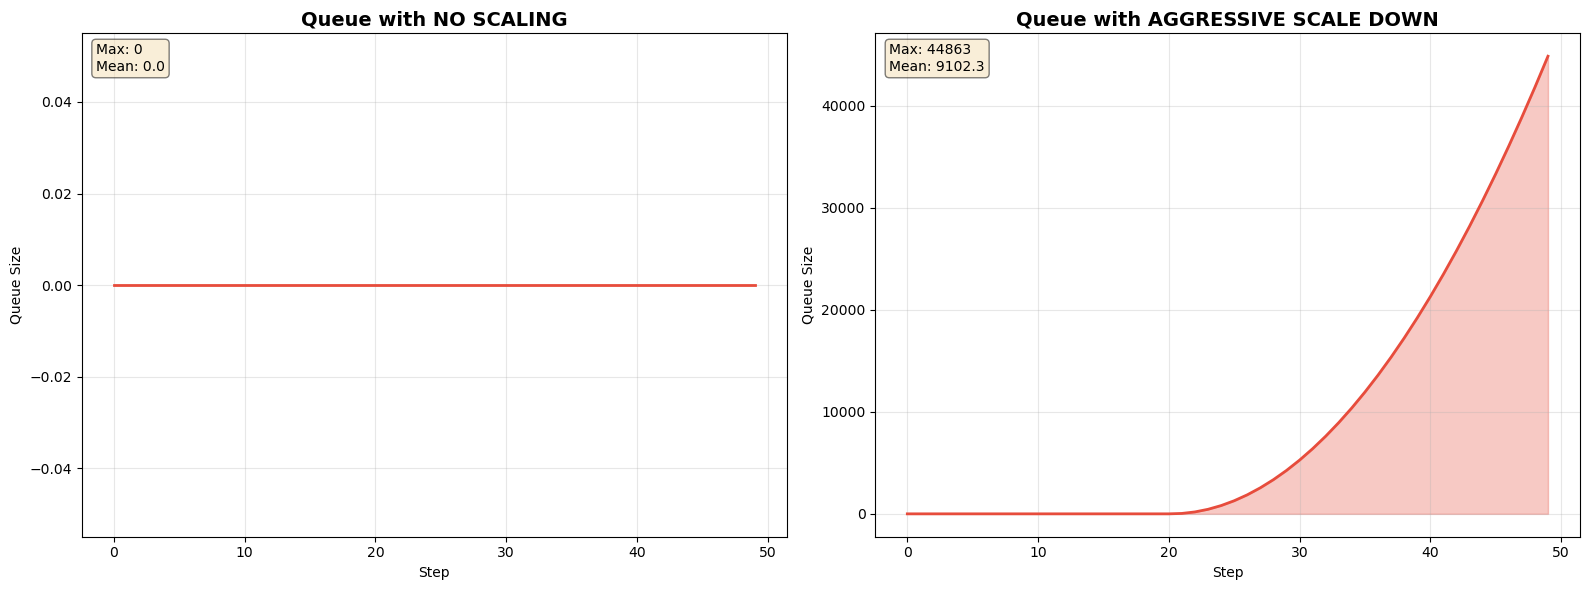


✓ Max queue (no scaling): 0.0
✓ Max queue (scale down): 44863.0

This proves the queue IS being tracked!
Your models keep queue at 0 because they scale efficiently.


In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: No scaling
axes[0].plot(queue_values, linewidth=2, color='#e74c3c')
axes[0].fill_between(range(len(queue_values)), queue_values, alpha=0.3, color='#e74c3c')
axes[0].set_title('Queue with NO SCALING', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Queue Size')
axes[0].grid(alpha=0.3)
axes[0].text(0.02, 0.98, f'Max: {max(queue_values):.0f}\nMean: {np.mean(queue_values):.1f}',
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Aggressive scale down
axes[1].plot(queue_values2, linewidth=2, color='#e74c3c')
axes[1].fill_between(range(len(queue_values2)), queue_values2, alpha=0.3, color='#e74c3c')
axes[1].set_title('Queue with AGGRESSIVE SCALE DOWN', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Queue Size')
axes[1].grid(alpha=0.3)
axes[1].text(0.02, 0.98, f'Max: {max(queue_values2):.0f}\nMean: {np.mean(queue_values2):.1f}',
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Max queue (no scaling): {max(queue_values):.1f}")
print(f"✓ Max queue (scale down): {max(queue_values2):.1f}")
print("\nThis proves the queue IS being tracked!")
print("Your models keep queue at 0 because they scale efficiently.")
